In [34]:
#import

import tensorflow as tf
#print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [60]:
#load model if already trained

model = load_model('NN_512')

In [ ]:
#create a new model

model = Sequential([Dense(256, activation='relu', input_shape=(510,)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(34, activation='softmax')
])

# 編譯模型
model.compile(
    optimizer='adam',              # 選擇 Adam 優化器
    loss='categorical_crossentropy', # 適用於多分類問題
    metrics=['accuracy']
)


In [ ]:
# 訓練模型

class IgnoreBadEpochs(Callback):
    def __init__(self):
        super().__init__()
        self.best_accuracy = 0.0  # 初始化最佳验证准确率
        self.best_weights = None  # 保存最佳模型权重

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('val_accuracy')
        if abs(current_accuracy - self.best_accuracy) < 0.01:
            # 如果当前验证准确率优于最佳结果，更新最佳结果和权重
            self.best_accuracy = current_accuracy
            self.best_weights = self.model.get_weights()  # 保存当前模型权重
            print(f"\nEpoch {epoch + 1}: New best accuracy ({current_accuracy:.4f}) saved.")
        else:
            # 如果表现变差，忽略当前结果
            print(f"\nEpoch {epoch + 1}: Accuracy dropped ({current_accuracy:.4f}), ignored.")

    def on_train_end(self, logs=None):
        # 在训练结束后恢复最佳权重
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print("\nRestored the best model weights with accuracy:", self.best_accuracy)

In [ ]:
#save train data

# 載入數據
folder_path = 'dataset_extracted'

# 創建一個空的 DataFrame，準備存放所有合併的數據
all_data = pd.DataFrame()

dataframes = []
cnt = 0
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path)
        dataframes.append(data)  # 將每個 DataFrame 添加到列表中
        cnt+=1
        if(cnt > 1000):
            break

# 一次性合併所有 DataFrame
all_data = pd.concat(dataframes, ignore_index=True)
 # 資料預處理
x_train = np.zeros((all_data.shape[0], all_data.shape[1] - 1))

p0_pov = 68
p0_meld = 102
p0_pool = 238
p0_discard = 374

def add_data(start):
    x_train[:, start:start+34] = all_data.iloc[:, start:start+34].values

add_data(p0_pov)
add_data(p0_meld)
add_data(p0_pool)
add_data(p0_discard)

y_train = all_data.iloc[:, -1].values  # 获取最后一列作为标签
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)

Epoch 1/20
6063/6065 [============================>.] - ETA: 0s - loss: 1.2974 - accuracy: 0.5586
Epoch 1: Accuracy dropped (0.5140), ignored.
6065/6065 [==============================] - 24s 4ms/step - loss: 1.2974 - accuracy: 0.5586 - val_loss: 1.5362 - val_accuracy: 0.5140
Epoch 2/20
6058/6065 [============================>.] - ETA: 0s - loss: 1.2965 - accuracy: 0.5586
Epoch 2: Accuracy dropped (0.5177), ignored.
6065/6065 [==============================] - 24s 4ms/step - loss: 1.2966 - accuracy: 0.5586 - val_loss: 1.5439 - val_accuracy: 0.5177
Epoch 3/20
6058/6065 [============================>.] - ETA: 0s - loss: 1.2950 - accuracy: 0.5598
Epoch 3: Accuracy dropped (0.5164), ignored.
6065/6065 [==============================] - 25s 4ms/step - loss: 1.2950 - accuracy: 0.5598 - val_loss: 1.5506 - val_accuracy: 0.5164
Epoch 4/20
6059/6065 [============================>.] - ETA: 0s - loss: 1.2941 - accuracy: 0.5593
Epoch 4: Accuracy dropped (0.5132), ignored.
6065/6065 [===============

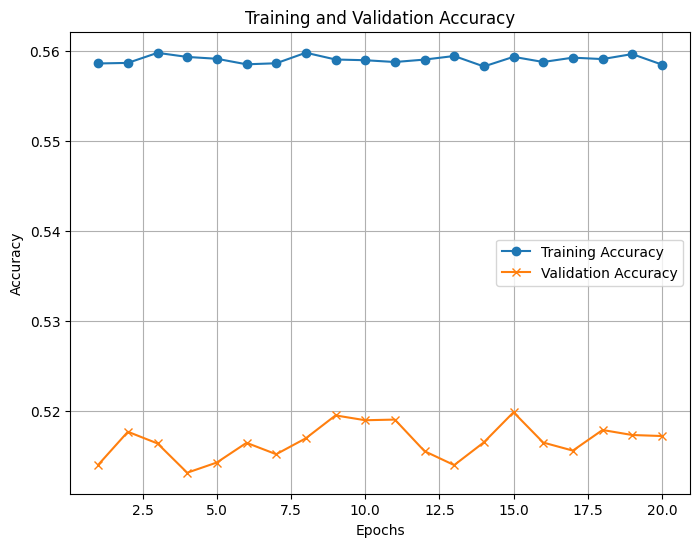

In [65]:
#load train data and train

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

# 将标签转为 One-Hot 编码
y_train_one_hot = tf.keras.utils.to_categorical(y_train)

# 使用回调函数训练模型
history = model.fit(
    x_train, y_train_one_hot,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[IgnoreBadEpochs()]  # 添加自定义回调
)


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# 繪製圖表
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [56]:
#save model
model.save('NN_512')

INFO:tensorflow:Assets written to: NN_512\assets


INFO:tensorflow:Assets written to: NN_512\assets


In [38]:
#確保輸出只有輸入

def filter_prediction(input_tiles, prediction):
    """
    过滤预测结果，确保输出的牌在玩家手牌内。
    
    Args:
        input_tiles (np.array): 玩家手牌 (长度为34的向量)
        prediction (np.array): 模型的输出 (长度为34的概率向量)
    
    Returns:
        int: 经过过滤后的输出牌索引
    """
    legal_tiles = np.where(input_tiles > 0)[1]  # 找到手牌中合法牌的索引
    prediction = prediction.reshape(34,)
    filtered_prediction = np.zeros_like(prediction)
    
    #print(f"合法牌索引：{legal_tiles}")
    #print(f"原始预测值：{prediction}")
    
    filtered_prediction[legal_tiles] = prediction[legal_tiles]
    
    #print(f"过滤后的预测值：{filtered_prediction}")
    
    return np.argmax(filtered_prediction)


In [36]:
#棄牌模型

def discard(hands_input):
    # 初始化手牌
    hands = np.zeros(34)  # 假设有 34 种牌

    # 根据 hands_input 中的牌来填充 hands 数组
    for tile in hands_input:
        hands[tile['type'] * 9 + tile['index'] - 1] += 1

    # 让模型预测
    hands = hands.reshape(1, 34)  # 使其成为符合模型要求的形状
    out = filter_prediction(hands, model.predict(hands))


    # 找到并返回对应的弃牌
    for i, tile in enumerate(hands_input):
        if tile['type'] * 9 + tile['index'] - 1 == out:
            return i

In [39]:
# 測試
hands = [1, 0, 0, 0, 0, 0, 0, 0, 0,  3, 0, 0, 0, 0, 0, 0, 0, 1,  1, 0, 0, 0, 0, 0, 0, 0, 1,  1, 1, 1, 1, 1, 1, 1]
#new =   [0, 0, 0, 0, 0, 0, 0, 0, 0,  1, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0]
new = 9

hands_input = [
    {'dora': False, 'type': 0, 'index': 3},
    {'dora': False, 'type': 0, 'index': 2},
    {'dora': False, 'type': 0, 'index': 3},
    {'dora': False, 'type': 1, 'index': 4},
    {'dora': False, 'type': 1, 'index': 5},
    {'dora': False, 'type': 1, 'index': 6},
    {'dora': False, 'type': 1, 'index': 7},
    {'dora': False, 'type': 1, 'index': 8},
    {'dora': False, 'type': 1, 'index': 9},
    {'dora': False, 'type': 2, 'index': 0},
    {'dora': False, 'type': 3, 'index': 1},
    {'dora': False, 'type': 3, 'index': 2},
    {'dora': False, 'type': 3, 'index': 3},
    {'dora': False, 'type': 3, 'index': 3}
]
print(discard(hands_input))

1/1 [==============================] - 0s 16ms/step
10


In [2]:
#吃碰槓模型

def action(type, combination, hands):
    #type : chi, pong, kong
    #combination: 23吃4萬 or 24吃3萬

    decision = 0 

    return decision